In [ ]:
# default_exp callback.gblend

# Gradient Blending

> Callback used to apply gradient blending to multi-modal models.

This is an unofficial PyTorch implementation by Ignacio Oguiza (timeseriesAI@gmail.com) based on: Wang, W., Tran, D., & Feiszli, M. (2020). **What Makes Training Multi-Modal Classification Networks Hard?**. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (pp. 12695-12705).

In [ ]:
#export
from fastai.callback.all import *
from tsai.imports import *
from tsai.utils import *
from tsai.data.preprocessing import *
from tsai.data.transforms import *
from tsai.models.layers import *

In [ ]:
#export
class GBlendLoss(Module):
    "Wrapper loss used by the gradient blending callback to allow weights applied to each modality."

    def __init__(self, crit=None, w=None):
        self.crit = ifnone(crit, CrossEntropyLossFlat())
        self.w = w
        
    def forward(self, preds, target):
        # unweighted loss
        if not is_listy(preds): return self.crit(preds, target)
        
        # weighted loss
        if self.w is None: self.w = tensor([1.] * len(preds))
        loss = 0
        for i, pred in enumerate(preds): loss += self.crit(pred, target) * self.w[i]
        return loss / sum(self.w)

In [ ]:
# export
class GBlend(Callback):
    r"""A callback to implement multi-modal gradient blending.
    
    This is an unofficial PyTorch implementation by Ignacio Oguiza of  - oguiza@gmail.com based on: Wang, W., Tran, D., & Feiszli, M. (2020). 
    What Makes Training Multi-Modal Classification Networks Hard?. In Proceedings of the IEEE/CVF Conference on Computer Vision and 
    Pattern Recognition (pp. 12695-12705).
    """

    def __init__(self, V_pct=.1, n:Union[None, int, tuple, list]=(10, 5), sel_metric:Optional[str]=None, show_plot:bool=False, path:str='./data/gblend'): 
        
        r"""
        Args:
            V_pct      : subset of train where OGR will be measured (to estimate L*)
            n          : None: offline learning, int: super-epoch (online learning), tuple: (warmup super-epoch, super-epoch)(online learning with warm up)
            sel_metric : which metric will be used to calculate overfitting and generalization during training. If None, loss will be used.
            show_plot  : will show a plot with the wieghts at the end of training
        """
        assert V_pct < 1, 'V_pct must be < 1'
        self.V_pct, self.n, self.sel_metric, self.show_plot = V_pct, n, sel_metric, show_plot
        self.metric_idx = None
        self.path = Path(path)
        if not os.path.exists(self.path): os.makedirs(self.path)

    def before_fit(self):
        
        # model
        self.learn.M = self.model.M 
        self.old_multi_output = self.learn.model.multi_output
        self.learn.model.multi_output = True

        #loss
        if cls_name(self.learn.loss_func) != 'GBlendLoss': self.learn.loss_func = GBlendLoss(crit=self.learn.loss_func)

        # calculate super_epochs
        if self.n is None: 
            self.super_epochs = [0]
        else: 
            if is_listy(self.n): 
                self.wu_n = self.n[0]
                self.n = self.n[1]
            else: 
                self.wu_n = self.n
            rng = range(int(max(0, self.n_epoch - self.wu_n) / self.n + 1))
            self.super_epochs = []
            for i in rng: 
                self.super_epochs.append((i * self.wu_n) if i <= 1 else int((i + self.wu_n / self.n - 1) * self.n))
        self.super_epochs.append(self.n_epoch)
        
        # create T'(Tp) and V dataloaders
        n_out = len(self.learn.dls.train.dataset.ptls) - self.learn.dls.train.dataset.n_inp
        train_targets = self.learn.dls.train.dataset.ptls[-n_out]
        Tp_idx, V_idx = get_splits(train_targets, valid_size=self.V_pct)
        _Tp_train_dls = []
        _V_train_dls = []
        self.learn.new_dls = []
        for dl in self.learn.dls[0].loaders: # train MixedDataLoaders
            _Tp_dl = get_subset_dl(dl, Tp_idx)
            _V_dl = get_subset_dl(dl, V_idx)
            _Tp_train_dls.append(_Tp_dl)
            _V_train_dls.append(_V_dl) 
            self.learn.new_dls.append(DataLoaders(_Tp_dl, _V_dl, device=self.learn.dls.device))
        self.learn.new_dls.append(MixedDataLoaders(MixedDataLoader(*_Tp_train_dls, shuffle=True),  # train - train
                                                   MixedDataLoader(*_V_train_dls, shuffle=False),  # train - valid
                                                   device=self.learn.dls.device))
        
        # prepare containers
        self.learn.LT = []
        self.learn.LV = []

    def before_train(self):
        if self.epoch in self.super_epochs[:-1] and not 'LRFinder' in [cls_name(cb) for cb in self.learn.cbs]: 
            self.train_epochs = np.diff(self.super_epochs)[self.super_epochs.index(self.epoch)]
            
            #compute weights
            self.learn.save('gblend_learner')
            torch.save(self.learn.model, self.path/'gblend_model')
            w = self.compute_weights()
            if self.epoch == 0: self.learn.ws = [w]
            else: self.learn.ws.append(w)
            self.learn = self.learn.load('gblend_learner')
            self.learn.loss_func.w = w

    def compute_weights(self):

        # _LT0 = []
        # _LV0 = []
        _LT = []
        _LV = []
        for i in range(self.learn.M + 1):            
            model = torch.load(self.path/'gblend_model')
            learn = Learner(self.learn.new_dls[i], model.m[i], loss_func=GBlendLoss(), 
                            opt_func=self.learn.opt_func, metrics=self.learn.metrics)
            learn.model.multi_output = False
            learn.remove_cbs(learn.cbs[1])
            learn.add_cb(Recorder(train_metrics=True))
            with learn.no_bar():
                with learn.no_logging(): 
                    learn.fit_one_cycle(self.train_epochs, pct_start=0)
            if self.metric_idx is None and self.sel_metric is not None:
                metric_names = learn.recorder.metric_names[1:-1]
                self.metric_idx = [i for i,m in enumerate(metric_names) if self.sel_metric in m]
            else: self.metric_idx = [0, 1]
            metric_values = learn.recorder.values[-1][self.metric_idx]
            _LT.append(metric_values[0])
            _LV.append(metric_values[1])

        # if self.epoch == 0: self.compute_previous_metrics()
        self.compute_previous_metrics()
        self.learn.LT.append(_LT)
        self.learn.LV.append(_LV)

        LT1 = array(self.learn.LT[-2])
        LT2 = array(self.learn.LT[-1])
        LV1 = array(self.learn.LV[-2])
        LV2 = array(self.learn.LV[-1])

        ΔG = (LV1 - LV2) if self.metric_idx[0] == 0 else (LV2 - LV1)
        O1 = (LV1 - LT1) if self.metric_idx[0] == 0 else (LT1 - LV1)
        O2 = (LV2 - LT2) if self.metric_idx[0] == 0 else (LT2 - LV2)

        ΔG = np.maximum(0, ΔG)

        ΔO = O2 - O1
        ΔO2 = np.maximum(1e-8, (O2 - O1)**2)
        w = np.maximum(1e-8, np.nan_to_num(ΔG / ΔO2))
        w = w / w.sum()
        w = w.tolist()
        return w

    def compute_previous_metrics(self):
        if self.metric_idx[0] == 0:  metric = self.loss_func
        else: metric = self.learn.metrics[(min(array(self.metric_idx) - 2) - 1) // 2]
        _LT = []
        _LV = []
        with torch.no_grad():
            for i in range(self.learn.M + 1):
                model = torch.load(self.path/'gblend_model')
                model.multi_output = False
                model = model.m[i]
                _train_metrics = []
                _valid_metrics = []
                for j,dl in enumerate(self.learn.new_dls[i]):
                    it = iter(dl)
                    _preds = []
                    _targets = []
                    for b in it: 
                        _preds.extend(model(*b[:-1]))
                        _targets.extend(b[-1])
                    _preds, _targets = stack(_preds), stack(_targets)
                    try: _metric_values = metric(_preds, _targets).cpu().item()
                    except: _metric_values = metric(torch.argmax(_preds, 1), _targets).cpu().item()
                    if j == 0: _LT.append(_metric_values)
                    else: _LV.append(_metric_values)
            self.learn.LT.append(_LT)
            self.learn.LV.append(_LV)

    def after_fit(self):
        if hasattr(self.learn, "ws") and self.show_plot:
            widths = np.diff(self.super_epochs)
            cum_ws = 0
            for i in range(self.learn.M + 1):
                plt.bar(self.super_epochs[:-1] + widths/2, stack(self.learn.ws)[:, i], bottom=cum_ws, width=widths, 
                        label=f'k={i+1}' if i < self.learn.M else f'fused')
                cum_ws += stack(self.learn.ws)[:, i]
            plt.xlim(0, self.super_epochs[-1])
            plt.ylim(0, 1)
            plt.xticks(self.super_epochs)
            plt.legend(loc='best')
            plt.title('Online G-Blend Weights by modality')
            plt.show()

        self.learn.model.multi_output = self.old_multi_output

In [ ]:
from fastai.data.transforms import *
from tsai.data.all import *
from tsai.models.utils import *
from tsai.models.XCM import *
from tsai.models.TabModel import *
from tsai.models.MultiInputNet import *
from tsai.learner import *

In [ ]:
dsid = 'NATOPS'
X, y, splits = get_UCR_data(dsid, split_data=False)
ts_features_df = get_ts_features(X, y)

Feature Extraction: 100%|██████████| 40/40 [00:04<00:00,  8.62it/s]


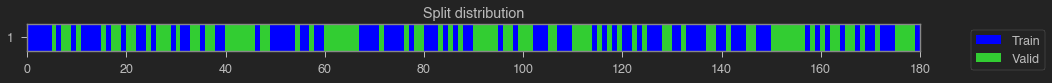

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.807015,1.592031,0.583333,0.895593,00:07


In [ ]:
# raw ts
tfms  = [None, [Categorize()]]
batch_tfms = TSStandardize()
ts_dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms)
ts_model = build_ts_model(XCM, dls=ts_dls, window_perc=.5)

# ts features
cat_names = None
cont_names = ts_features_df.columns[:-2]
y_names = 'target'
tab_dls = get_tabular_dls(ts_features_df, cat_names=cat_names, cont_names=cont_names, y_names=y_names, splits=splits)
tab_model = build_tabular_model(TabModel, dls=tab_dls)

# mixed
mixed_dls = get_mixed_dls(ts_dls, tab_dls)
MultiModalNet = MultiInputNet(ts_model, tab_model, c_out=mixed_dls.c)
gblend = GBlend(V_pct=.5, n=(10, 5), sel_metric=None)
learn = Learner(mixed_dls, MultiModalNet, metrics=[accuracy, RocAuc()], cbs=gblend)
learn.fit_one_cycle(1, 1e-3)

In [ ]:
#hide
out = create_scripts(); beep(out)